# Cumulative Throughput Test with OpenVINO™

This application loads a video, preprocesses every frame, and stores the frames into a framebuffer. It then runs inference using `ssd_mobilenet_v1_fpn_coco` on every frame. It records the amount of time it takes to inference the whole framebuffer. As an output, it reports every object that was detected in the video as well as the total inference processing time.

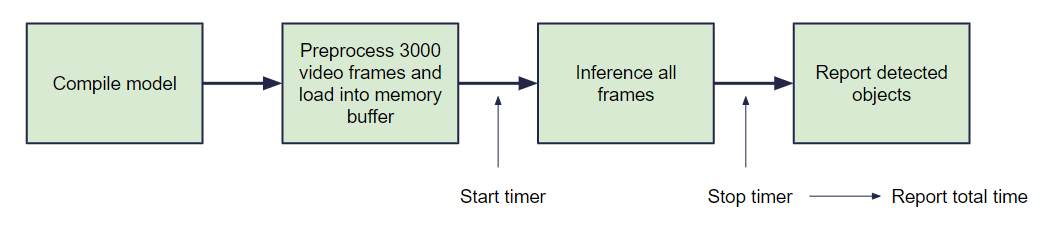


## Download and convert the model
This tutorial uses the [googlenet-v1](https://docs.openvino.ai/latest/omz_models_model_googlenet_v1.html) model from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/). The googlenet-v1 model is the first of the [Inception](https://github.com/tensorflow/tpu/tree/master/models/experimental/inception) family of models designed to perform image classification. Like other Inception models, googlenet-v1 was pre-trained on the [ImageNet](https://image-net.org/) data set. For more details about this family of models, see the [research paper](https://arxiv.org/abs/1512.00567).

The following code downloads googlenet-v1 and converts it to OpenVINO IR format `(model/public/googlenet-v1/FP16/googlenet-v1.xml)`. For more information about Open Model Zoo tools, refer to the [104-model-tools](../104-model-tools/README.md) tutorial.

## Download and convert the model

We'll use `ssd_mobilenet_v1_fpn_coco` for this application.

In [1]:
import os
# A directory where the model will be downloaded.
base_model_dir = "model"

# The name of the model from Open Model Zoo
#model_name = "ssdlite_mobilenet_v2"
#model_name = "efficientdet-d1-tf"
#model_name = "faster_rcnn_resnet50_coco"
model_name = "ssd_mobilenet_v1_fpn_coco"

model_path = f"model/public/{model_name}"

if not os.path.exists(model_path):
    download_command = f"omz_downloader " \
                       f"--name {model_name} " \
                       f"--output_dir {base_model_dir} " \
                       f"--cache_dir {base_model_dir}"
    ! $download_command

In [2]:
precision = "FP16"

# The output path for the conversion.
converted_model_path = f"model/public/{model_name}/{precision}/{model_name}.xml"

if not os.path.exists(converted_model_path):
    convert_command = f"omz_converter " \
                      f"--name {model_name} " \
                      f"--download_dir {base_model_dir} " \
                      f"--precisions {precision}"
    ! $convert_command

## Import modules

In [3]:
from pathlib import Path
from IPython.display import Markdown, display
import cv2
import matplotlib.pyplot as plt
import numpy as np
from openvino.runtime import Core, CompiledModel, AsyncInferQueue, InferRequest
import sys
import time

ie_core = Core()
print(ie_core.available_devices)

['CPU', 'GPU.0', 'GPU.1']


## Compile Model

In [24]:
# Read the network and corresponding weights from a file.
model = ie_core.read_model(model=converted_model_path)
# Compile the model for CPU (you can choose manually CPU, GPU, MYRIAD etc.)
# or let the engine choose the best available device (AUTO).
compiled_model = ie_core.compile_model(model=model, device_name="CPU")
#compiled_model = ie_core.compile_model(model=model, device_name="AUTO", config={"PERFORMANCE_HINT":"CUMULATIVE_THROUGHPUT"})

# Get the input and output nodes.
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

input_keys = list(compiled_model.inputs)
print(input_keys)

# Get the input size.
num, height, width, channels = input_layer.shape
print('Model input shape:', num, height, width, channels)

[<ConstOutput: names[image_tensor, image_tensor:0] shape[1,640,640,3] type: u8>]
Model input shape: 1 640 640 3


In [26]:
[i.any_name for i in input_keys]

['image_tensor']

## Define Model Output Classes

In [12]:
# COCO classes! (the dataset, not the dog)
classes = [
    "background", "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train",
    "truck", "boat", "traffic light", "fire hydrant", "street sign", "stop sign",
    "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant",
    "bear", "zebra", "giraffe", "hat", "backpack", "umbrella", "shoe", "eye glasses",
    "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite",
    "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle",
    "plate", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
    "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair",
    "couch", "potted plant", "bed", "mirror", "dining table", "window", "desk", "toilet",
    "door", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven",
    "toaster", "sink", "refrigerator", "blender", "book", "clock", "vase", "scissors",
    "teddy bear", "hair drier", "toothbrush", "hair brush"
]

## Load and Preprocess Video Frames

In [13]:
### Load video
#video_file = "../201-vision-monodepth/data/Coco Walking in Berkeley.mp4"
video_file = "../401-object-detection-webcam/IMG_4416.MOV"
vid = cv2.VideoCapture(video_file)
framebuf = []

print('Loading video...')
while vid.isOpened():
        ret,frame = vid.read()
        if not ret:
                print('Video loaded!')
                break
        
        # Preprocess frames - convert them to shape expected by model
        #resized_frame = cv2.resize(frame, (W, H))
        input_frame = cv2.resize(src=frame, dsize=(width, height), interpolation=cv2.INTER_AREA)
        input_frame = input_frame[np.newaxis, ...]
        
        # Append frame to framebuffer
        framebuf.append(input_frame)

print('Frame shape: ', framebuf[0].shape)
print('Number of frames: ', len(framebuf))

Loading video...
Video loaded!
Frame shape:  (1, 640, 640, 3)
Number of frames:  1842


## Set up Asynchronous Pipeline


### Callback definition

In [18]:
def completion_callback(infer_request: InferRequest, results) -> None:
    predictions = next(iter(infer_request.results.values()))
    results.append(predictions[:10]) # Grab first 10 predictions for this frame

### Create async pipeline

In [19]:
# Create async queue with optimal number of infer requests
infer_queue = AsyncInferQueue(compiled_model)
infer_queue.set_callback(completion_callback)

### Perform inference

In [20]:
results = []
start_time = time.time()
for i, input_frame in enumerate(framebuf):
    infer_queue.start_async({0: input_frame}, results)

infer_queue.wait_all()
stop_time = time.time()

total_time = stop_time - start_time
time_per_frame = total_time / len(framebuf)
fps = len(framebuf) / total_time
print(f'Total time to inference all frames: {stop_time-start_time:.3f}s')
print(f'Time per frame: {time_per_frame:.6f}s ({fps:.3f} FPS)')

Total time to inference all frames: 327.842s
Time per frame: 0.177981s (5.619 FPS)


### Process results

In [10]:
# Set minimum detection threshold
min_thresh = .6

# Initialize list of detected objects
detected_objs = []

# Go through results for every frame
for result in results:
    result = np.squeeze(result)

    # For each prediction, check if it's above min threshold and hasn't already been detected
    for prediction in result:
        conf = prediction[2]
        obj_class = classes[int(prediction[1])]
        if conf > min_thresh and obj_class not in detected_objs:
            detected_objs.append(obj_class)

# Print list of detected objects
print('The following objects were detected in this video:')
for obj in detected_objs:
    print(obj)

The following objects were detected in this video:
truck
car
